# problem formulation:

### Define the problem ?

- For this competition, a dataset with graphs and nodes representing chemical substances was provided to us. In order to solve the binary classification problem of predicting whether a given chemical component is non-small cell lung cancer or not, we must develop a deep learning model using GNN.

### what is the input?
- We were provided with SDF file data, which included samples describing chemical compounds. After parsing the file, we extracted the symbols representing the constituent elements, tokenized them later, and handled them as nodes in the graph. Additionally, the SDF file contained information about the chemical bonds between the elements, which we treated as edges in the graph representation. Finally, since we were training our model in batches, there was a node2graph that served as a segmentid for the graphs in the batch.
Consequently, we have nodes:symbol embedding of elements
- edges: these show the chemical compound's bonds.

- node2graph: used to identify the graph's edge within the batches.


### what is the output?

This model's output will be a prediction of whether or not a person has non-small cell lung cancer, making it a binary classification problem where we are primarily concerned with the positive class. However, the output will naturally be a number in the range [0,1]. We can use a threshold (0.5 in most cases) if the number is greater than 0.5, in which case the prediction will be one or zero.

###  what is the data mining function required ?

- The binary classification function was utilized as the mining function in this problem, and the following procedures were followed:
**Data pretreatment and cleaning**: Thank you; the dataset was already clean; all we had to do was read the SDF file and parse the data. After that, we ran into issues with imbalanced data, so I used random oversampling.
**Modeling** : - **Definition**: characterize the issue as a binary classification problem; ascertain the evaluation measure (in our instance, ACUC); attempt several models with various hyperparameters.

I'll go into further detail about this under the question concerning experimental protocol and preparation.
Model evaluation involves comparing the best scoring measure to determine which model is the best.

### what are the challanges?

 – the first being, naturally, ignorance in this area.
  For instance, I may have discovered outliers but am unsure if they truly are.
  - The dataset was provided to us in SDF format, which I had never seen before. However, I am grateful that this competition has made it easier for me to understand as it is actually quite straightforward.

  Asymmetry exists in the dataset.
  Examining and adjusting the hyperparameters of various models.
  - some models require a lot of time to train and produce subpar outcomes.


### what is the impact ?

- Using GNN (Graph Neural Networks) to create an AI model that can classify anticancer activity can have a big influence on the development of novel cancer treatments by enabling quicker and more precise screening of possible drug candidates. The eventual result of this could be the development of novel treatments and better patient outcomes.

### what is the ideal solution ?
- To create a model with high performance and ease of sample classification, the optimum answer would be to have a large, clean dataset and powerful processing capacity. However, in my case, the ideal approach would have been to use GNN with the following parameters
  - params["hidden_dim"] = 32
  - params["num_heads"] = 8
  - params['num_aggr_MLP_hidden_layers'] = 16
  - params["global_exchange_mode"] ='gru'
  - params['message_calculation_class'] = 'ggnn'

it gets me 0.86 AUC on kaggle.

### what is th experimental protocol used ?What preprocessing steps are used?

 We employed a pre-experimental approach in which we compared various treatments (our studies with various models and features) to a single outcome (in our instance, the auc-score)

- The person who executed this was:
- preprocess and manage the experiment's data:
  - import the libraries and package contents.

  - read the SD file.
  - parse the helpful data from the SDF file.
  Establish procedures for creating batches that are compatible with Keras fit and forecast.

  - try to understand the dataset using visualziation.
  - there wasn't any missing values in this dataset.
  - build more than one model with different hyperparameter to find the best model.
  - using different massage passing techniques as (RGCN,GGNN,RGIN,RGAT)then observe the result through evaluation function.
  - upsample minority class in the dataset then try to build the models again.
  - choose the best model which gives the highest auc.



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cisc873-dm-w24-a6/train.sdf
/kaggle/input/cisc873-dm-w24-a6/test_x.sdf
/kaggle/input/cisc873-dm-w24-a6/gcnn-template.ipynb


In [ ]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow==2.x

ERROR: Could not find a version that satisfies the requirement tensorflow==2.x (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.x
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install --quiet tf2_gnn
import tensorflow
from tf2_gnn.layers.gnn import GNN, GNNInput
import tensorflow as tf
import math
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix

In [ ]:
import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
random.seed(0)
import tensorflow
from tf2_gnn.layers.gnn import GNN, GNNInput
import tensorflow as tf
import math
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix

**read data**

In [ ]:
def read_sdf(file):
  # open the file with read previliage using context manager
    with open(file, 'r') as rf:
      # read the whole file and store it in string
        content = rf.read()
    # split the files into samples to parse them our separator here is $$$$
    samples = content.split('$$$$')
    def parse_sample(s):
      # split the sample into lines
        lines = s.splitlines()
      # create container lists to carry the values for the elements and bonds
      # this list will carry the bonds
        links = []
      # this list will carry the elements
        nodes = []
      # create label variable and intialize it with zero in order to change its value in the if condition
        label = 0
      # looping over the sample lines and start to fill the list
        for l in lines:
      # the easiest line to check is the label it only contains the sample label in it so we strip the string and check if it's 1 or -1
            if l.strip() == '1.0':
                label = 1
      # changing the label from -1 to 0
            if l.strip() == '-1.0':
                label = 0
      # check if the line is a part from the atom block
            if l.startswith('    '):
      # split the line using space as separator and get the fourth value which is our element symbol
                feature = l.split()
                node = feature[3]
      # append the symbol in the nodes list
                nodes.append(node)
      # check if the line descripe a bond
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, # zero-based index
                        int(lnk[1])-1, # zero-based index

                    ))
        return nodes, np.array(links), label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [ ]:
#reading the samples and validate the parsing
training_set = read_sdf('/kaggle/input/cisc873-dm-w24-a6/train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
# converting the dataset into pandas dataframe
df = pd.DataFrame(training_set, columns=['Elements', 'bonds', 'Label'])
df.head()

,Elements,bonds,Label
0,"[S, O, O, O, O, N, N, N, C, C, C, C, C, C, C, ...","[[0, 8], [0, 14], [1, 10], [2, 11], [3, 7], [4...",0
1,"[O, O, O, O, O, O, N, N, N, C, C, C, C, C, C, ...","[[0, 6], [0, 15], [1, 15], [2, 7], [3, 8], [4,...",0
2,"[F, F, F, O, O, O, O, O, N, N, C, C, C, C, C, ...","[[0, 19], [1, 19], [2, 19], [3, 16], [4, 28], ...",0
3,"[Cl, S, S, O, O, O, O, N, N, N, N, C, C, C, C,...","[[0, 12], [1, 15], [1, 18], [2, 4], [2, 5], [2...",0
4,"[S, O, O, N, N, N, N, N, N, C, C, C, C, C, C, ...","[[0, 1], [0, 2], [0, 5], [0, 9], [3, 4], [3, 1...",0


In [ ]:
df.isna().sum()

Elements    0
bonds       0
Label       0
dtype: int64

as we see we don't have any nulls

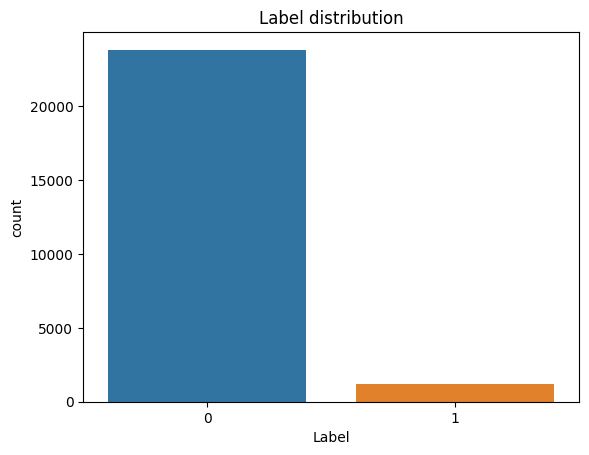

In [ ]:
sns.countplot(x='Label',data=df);
plt.title('Label distribution');

as we see here the data is  imbalanced,let's try to handle it

**visualizing a sample**

In [ ]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
# choosing the color map
color_map = cm.coolwarm

# Generate colors from the colormap
colors = cm.ScalarMappable(cmap=color_map).to_rgba(np.linspace(0, 1, 50))

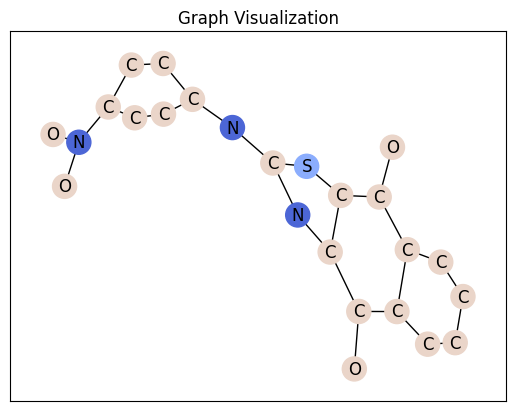

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def visualize(sample):

    G = nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    labeldict = {}
    node_color = []

    for i, n in enumerate(nodes):
        G.add_node(i)
        labeldict[i] = n
        # Safe color indexing using modulo operation
        color_index = hash(n) % len(colors)
        node_color.append(colors[color_index if color_index >= 0 else -color_index])

    for e in edges:
        G.add_edge(e[0], e[1])

    # Use a layout that spreads nodes in an aesthetically pleasing manner
    pos = nx.spring_layout(G)  # Positions nodes using Fruchterman-Reingold force-directed algorithm
    nx.draw_networkx(G, pos, labels=labeldict, with_labels=True, node_color=node_color)
    plt.title('Graph Visualization')
    plt.show()

    return G


plt.clf()
G = visualize(training_set[0])


This visualization represents the first sample, which contains 23 atoms connected by 28 bonds, as depicted in the provided example of the SDF sample.

In [ ]:
# return the number of bonds in the compound
def num_bonds(x):
  return x.shape[0]
df['number of bonds']=df.bonds.apply(num_bonds)

In [ ]:
# return the number of elements in the compound
def num_elements(x):
  return len(x)
df['number of elements']=df.Elements.apply(num_elements)

**reading the data and split the training set into train and validation set**

In [ ]:
# reading the training set
training_set = read_sdf('/kaggle/input/cisc873-dm-w24-a6/train.sdf')
# reading the testing set
testing_set  = read_sdf('/kaggle/input/cisc873-dm-w24-a6/test_x.sdf')
# split the training set into training and validation set
training_set, validation_set = train_test_split(training_set, test_size=0.2,)

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

**preparing the batch**

In [ ]:
def prepare_single_batch(samples,tokenizer):
  # extract the nodes from the samples
    sample_nodes = [s[0] for s in samples]
  # convert the symbols to sequences
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
  # padding the sequences to make all of them have fixed input shape
    sample_nodes = pad_sequences(sample_nodes, padding='post')
  # find the maximum len of nodes sequence
    max_nodes_len = np.shape(sample_nodes)[1]
  # extracting the edges from the sample
    edges = [s[1] + i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
  # define the id of each edge to one of samples (segments)
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
  # flatten the node
    all_nodes = np.reshape(sample_nodes, -1)
  # concate the edges of the samples forming the batch
    all_edges = np.concatenate(edges)
  # flatten the node to graph
    node_to_graph = np.reshape(node_to_graph, -1)
    # return the nodes ,egdes,segments,label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



In [ ]:
import random
# this function is used to call prepare single batch and create the batches for the dataset
def gen_batch(dataset, tokenizer, batch_size=16, repeat=False, shuffle=True):

    # Convert the dataset to a list once if not iterating indefinitely
    dataset = list(dataset)
    while True:
        # Shuffle the dataset at the beginning of each pass through the data
        if shuffle:
            random.shuffle(dataset)
        # Determine the length of the dataset
        dataset_length = len(dataset)
        # Generate batches
        for start_idx in range(0, dataset_length, batch_size):
            end_idx = min(start_idx + batch_size, dataset_length)
            batch_samples = dataset[start_idx:end_idx]
            batch_data, batch_labels = prepare_single_batch(batch_samples, tokenizer)
            yield batch_data, batch_labels
        # Break the loop after one pass if repeat is False
        if not repeat:
            break


In [ ]:
from tensorflow.keras.layers import Dropout

def preprocess_build_model(training_set, max_vocab, max_len, params):
    # Set maximum vocabulary size
    max_vocab = max_vocab
    # Set maximum length of input sequences
    max_len = max_len

    # Extract all nodes from the training set
    all_nodes = [s[0] for s in training_set]
    # Create tokenizer object and fit it on the nodes
    tokenizer = Tokenizer(num_words=max_vocab)
    tokenizer.fit_on_texts(all_nodes)

    # Define input layers
    data = keras.Input(batch_shape=(None,))
    edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
    node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
    # Embed input data using tokenizer
    embeded = Embedding(tokenizer.num_words, max_len)(data)

    # Find the number of graphs in the batch
    num_graph = tf.reduce_max(node2graph) + 1

    # Prepare input for the GNN
    gnn_input = GNNInput(
        node_features=embeded,
        adjacency_lists=(edge,),
        node_to_graph_map=node2graph,
        num_graphs=num_graph,
    )

    # Create the GNN layer and apply it to the input
    gnn_layer = GNN(params)
    gnn_out = gnn_layer(gnn_input)

    # Compute the mean of the graph-level embeddings
    avg = segment_mean(
        data=gnn_out,
        segment_ids=node2graph
    )

    # Define the fully connected layers for classification
    layer_1 = Dense(64, activation='relu')(avg)
    # Add Dropout layer to reduce overfitting
    layer_1 = Dropout(0.5)(layer_1)
    layer_2 = Dense(32, activation='relu')(layer_1)
    pred = Dense(1, activation='sigmoid')(layer_2)

    # Define the model with inputs and outputs
    model = Model(
        inputs={
            'data': data,
            'edges': edge,
            'node2grah': node2graph,
        },
        outputs=pred
    )

    # Print the model summary
    model_summary = model.summary()

    # Compile the model with specified loss and metrics
    model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['AUC'])

    # Return tokenizer and model
    return tokenizer, model


In [ ]:
def evaluate(history, y_train, y_train_pred, y_val, y_val_pred):
    # Create a 2x2 figure for plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot the training and validation error curves
    axs[0, 0].plot(history.history['loss'], label='Training Error')
    axs[0, 0].plot(history.history['val_loss'], label='Validation Error')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Error')
    axs[0, 0].legend()

    # Plot the training and validation AUC curves
    axs[0, 1].plot(history.history['auc'], label='Training AUC')
    axs[0, 1].plot(history.history['val_auc'], label='Validation AUC')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('AUC')
    axs[0, 1].legend()

    # Plot the confusion matrix for the training data
    y_train_pred =  (y_train_pred > 0.5).astype(int)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(train_conf_matrix, annot=True, cmap='Blues', fmt='g', ax=axs[1, 0])

    axs[1, 0].set_xlabel('Predicted label')
    axs[1, 0].set_ylabel('True label')
    axs[1, 0].set_title('Training Confusion Matrix')

    # Plot the confusion matrix for the validation data
    y_val_pred =  (y_val_pred > 0.5).astype(int)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(val_conf_matrix, annot=True, cmap='Blues', fmt='g', ax=axs[1, 1])
    axs[1, 1].set_xlabel('Predicted label')
    axs[1, 1].set_ylabel('True label')
    axs[1, 1].set_title('Validation Confusion Matrix')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    # Show the plot
    plt.show()

In [ ]:
def train_and_evaluate(training_set, validation_set, testing_set, tokenizer, model, batch_size, epoch):
    # Set batch size and compute number of batches for training and validation sets
    batch_size = batch_size
    num_batches = math.ceil(len(training_set) / batch_size)
    num_batches_validation = math.ceil(len(validation_set) / batch_size)

    # Train the model and store the history object
    history = model.fit(
        # Generate batches from the training data
        gen_batch(training_set, tokenizer, batch_size=batch_size, repeat=True),
        steps_per_epoch=num_batches,  # Number of batches to use in each epoch of training
        epochs=epoch,  # Number of epochs
        validation_data=gen_batch(validation_set, tokenizer, batch_size=32, repeat=True),
        validation_steps=num_batches_validation
    )

    # Extract true labels and predictions for training and validation sets
    y_train_true = [row[2] for row in training_set]
    y_val_true = [row[2] for row in validation_set]
    y_train_pred = model.predict(gen_batch(training_set, tokenizer, batch_size=32, shuffle=False))
    y_train_pred = np.reshape(y_train_pred, -1)
    y_val_pred = model.predict(gen_batch(validation_set, tokenizer, batch_size=32, shuffle=False))
    y_val_pred = np.reshape(y_val_pred, -1)

    # Evaluate the model
    evaluate(history, y_train_true, y_train_pred, y_val_true, y_val_pred)

    # Generate predictions on the testing set
    y_pred = model.predict(gen_batch(testing_set, tokenizer, batch_size=32, shuffle=False))
    y_pred = np.reshape(y_pred, -1)  # Reshape predictions into a 1D array

    return model


**Trial 1**

in this trial i will use num layers 8 with hidden dim 32 and drop out 0.2

In [ ]:
params = GNN.get_default_hyperparameters()
params["num_layers"] = 8
params["hidden_dim"] = 32
params['layer_input_dropout_rate']=0.3
tokenizer,model=preprocess_build_model(training_set,100,200,params)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max (TFOpLa  ()                           0         ['input_3[0][0]']             
 mbda)                                                                                            
                                                                                                  
 embedding (Embedding)       (None, 200)                  20000     ['input_1[0][0]']         

Epoch 1/20
626/626 [==============================] - 47s 59ms/step - loss: 0.2315 - auc: 0.5178 - val_loss: 0.1955 - val_auc: 0.6118
Epoch 2/20
626/626 [==============================] - 37s 59ms/step - loss: 0.1929 - auc: 0.6126 - val_loss: 0.1898 - val_auc: 0.6230
Epoch 3/20
626/626 [==============================] - 35s 57ms/step - loss: 0.1923 - auc: 0.6177 - val_loss: 0.1762 - val_auc: 0.6040
Epoch 4/20
626/626 [==============================] - 37s 59ms/step - loss: 0.1902 - auc: 0.6352 - val_loss: 0.1857 - val_auc: 0.6664
Epoch 5/20
626/626 [==============================] - 35s 55ms/step - loss: 0.1878 - auc: 0.6551 - val_loss: 0.1908 - val_auc: 0.6298
Epoch 6/20
626/626 [==============================] - 35s 56ms/step - loss: 0.1871 - auc: 0.6681 - val_loss: 0.1602 - val_auc: 0.7181
Epoch 7/20
626/626 [==============================] - 35s 56ms/step - loss: 0.1834 - auc: 0.6922 - val_loss: 0.1687 - val_auc: 0.7469
Epoch 8/20
626/626 [==============================] - 35s 55ms

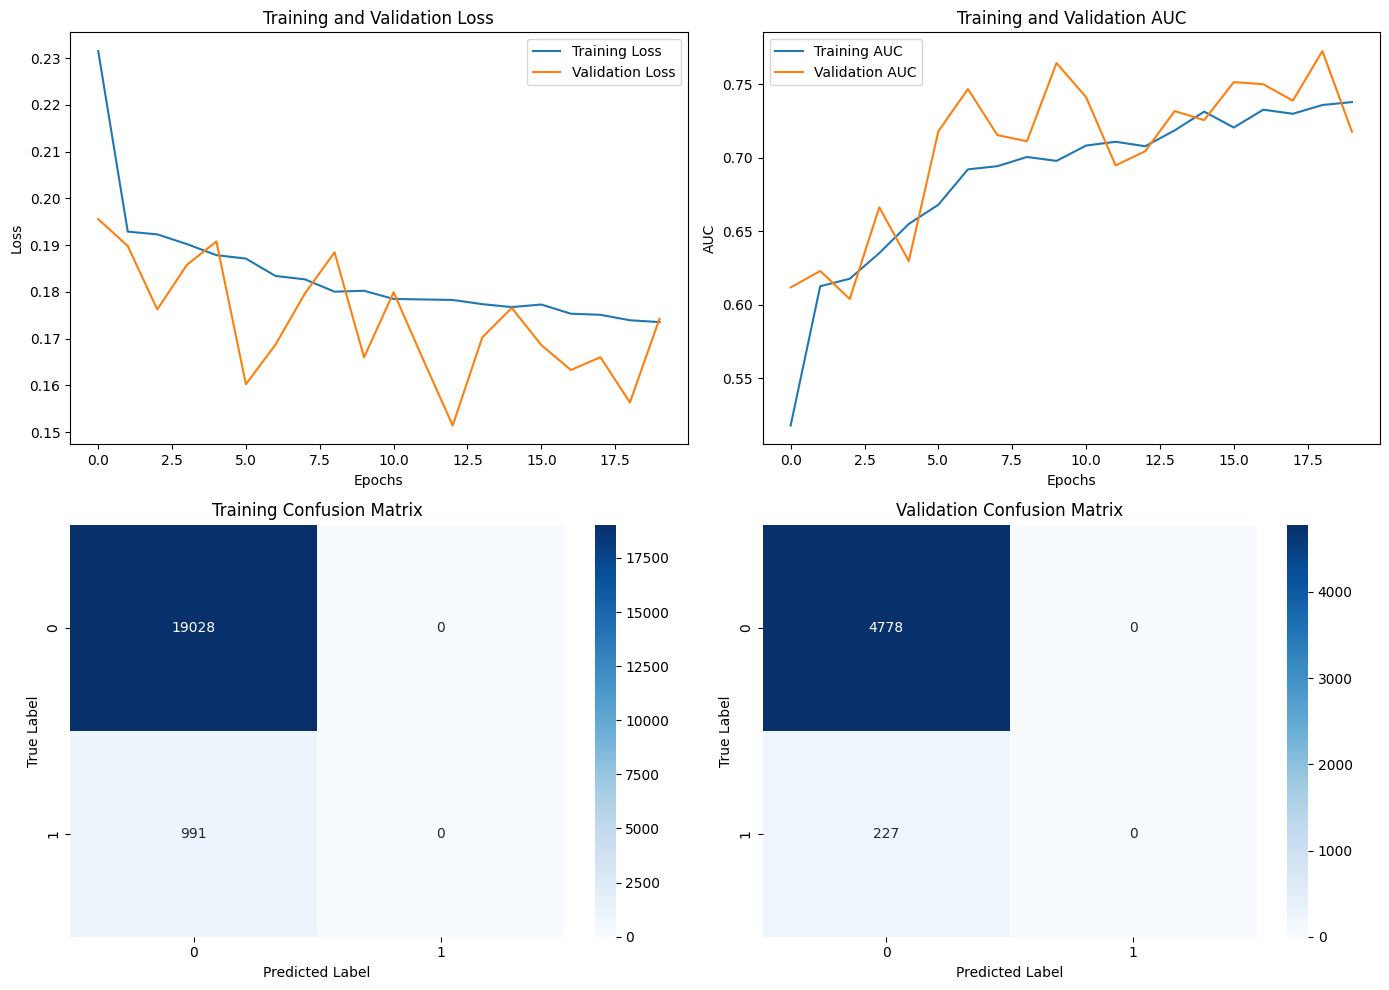

771/771 [==============================] - 8s 11ms/step


In [ ]:
train_and_evaluate(training_set,validation_set,testing_set,tokenizer,model,32,20,'dropoutwithlayers')

In [ ]:
 # Create a submission file for the Kaggle competition
    submission = pd.DataFrame({'label': y_pred})  # Create a DataFrame for the predictions
    submission.index.name = 'id'  # Set the index name
    submission.to_csv(f'sample_submission_dropoutwithlayers.csv')  # Save the predictions to a CSV file

**trail 2**


In this trial, I'll only use the hidden dimension hyperparameter set to 32. My experiments have shown that despite there being 118 elements, the tokenizer only uses up to 59 word indices due to the characteristics of the elements being tokenized. The longest chemical compound in the dataset is 223 elements long. Based on my exploratory data analysis, I found that more complex chemical compounds tend to be associated with class 1. Therefore, I've set the maximum sequence length to 200 to capture this complexity effectively.

In [ ]:
# Set hyperparameters for the GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
# preprocess_build_model(training_set,max_vocab,max_len,num_layers, num_heads, hidden_dim, message_calculation_class, global_exchange_mode)
tokenizer,model=preprocess_build_model(training_set,100,200,params)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_3 (TFOp  ()                           0         ['input_9[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 embedding_2 (Embedding)     (None, 200)                  20000     ['input_7[0][0]']       

Epoch 1/20
626/626 [==============================] - 19s 24ms/step - loss: 0.2214 - auc: 0.5746 - val_loss: 0.1689 - val_auc: 0.7191
Epoch 2/20
626/626 [==============================] - 15s 23ms/step - loss: 0.1851 - auc: 0.6814 - val_loss: 0.1893 - val_auc: 0.6992
Epoch 3/20
626/626 [==============================] - 14s 22ms/step - loss: 0.1822 - auc: 0.7047 - val_loss: 0.1682 - val_auc: 0.7265
Epoch 4/20
626/626 [==============================] - 15s 24ms/step - loss: 0.1809 - auc: 0.7097 - val_loss: 0.1883 - val_auc: 0.7109
Epoch 5/20
626/626 [==============================] - 14s 22ms/step - loss: 0.1775 - auc: 0.7285 - val_loss: 0.1626 - val_auc: 0.7869
Epoch 6/20
626/626 [==============================] - 14s 23ms/step - loss: 0.1765 - auc: 0.7327 - val_loss: 0.1664 - val_auc: 0.7425
Epoch 7/20
626/626 [==============================] - 14s 22ms/step - loss: 0.1750 - auc: 0.7412 - val_loss: 0.1666 - val_auc: 0.7873
Epoch 8/20
626/626 [==============================] - 14s 22ms

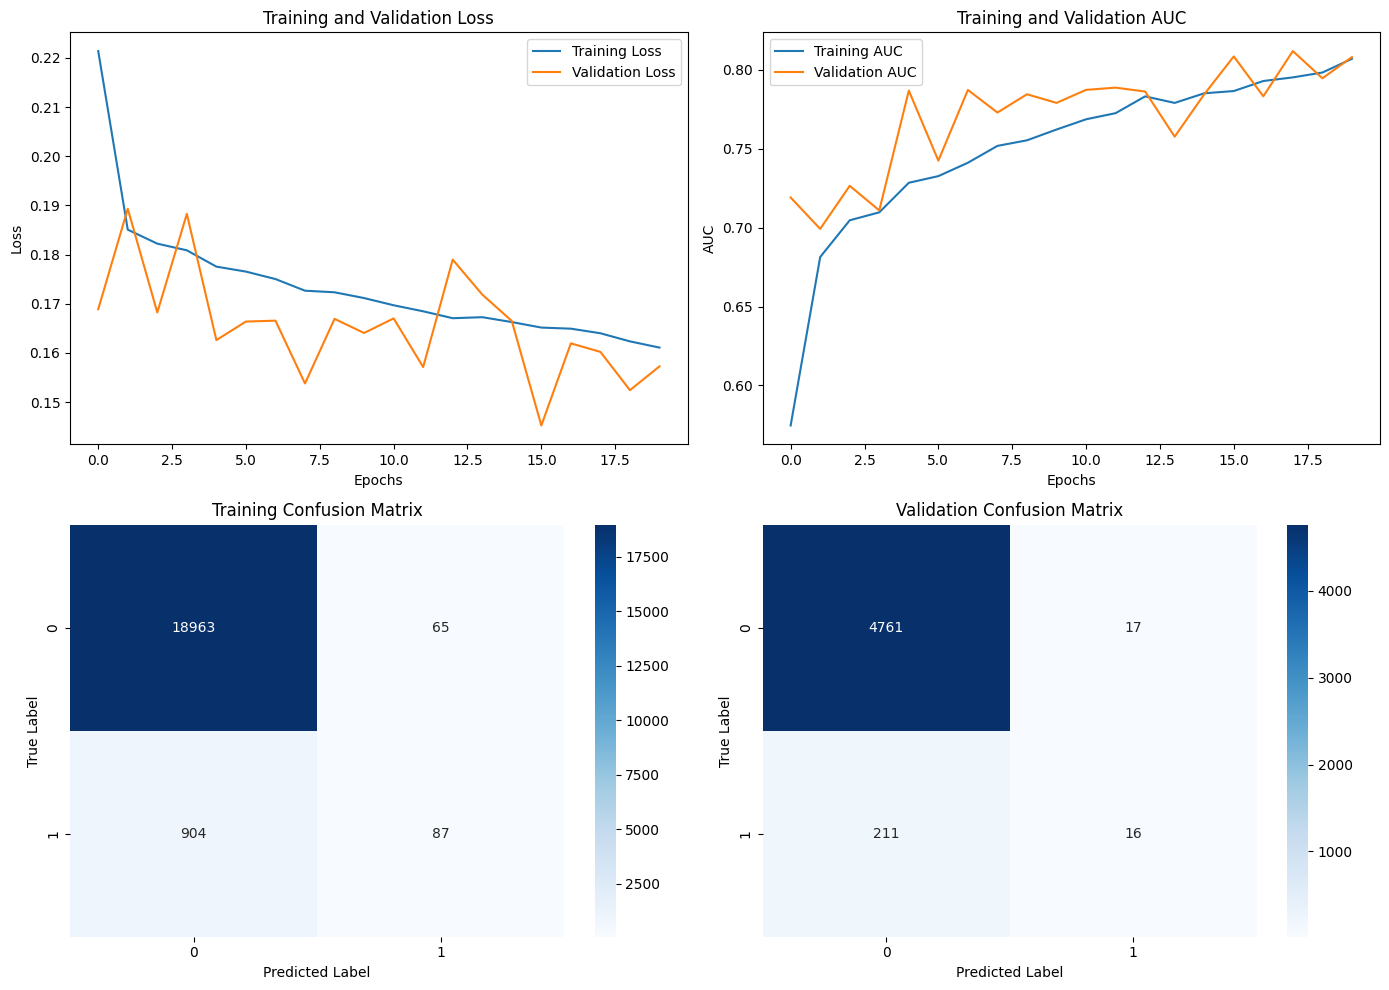

771/771 [==============================] - 5s 7ms/step


In [ ]:
train_and_evaluate(training_set,validation_set,testing_set,tokenizer,model,32,20)


I initially extended the model's training  to 20 epochs after noticing it was still learning, reaching an AUC around 81%. Despite this, the model had trouble identifying class 1 accurately, only correctly predicting a small number of class 1 instances in both training and validation sets.

Trying to improve this, I increased the hidden dimensions to 64, but this change led to a model that simply labeled all graphs as class 0, which was not useful at all. These observations were based on experiments with a hidden dimension of 32, and I noticed some slight changes when I tried recreating the model setup.

For my next step, I'm planning to experiment with adding more layers to the model by adjusting the 'num_layers' hyperparameter. This will increase the number of layers in the GNN model that process input features and update node representations, in hopes of better capturing the complex patterns of class 1.

In [ ]:
# Create a submission file for the Kaggle competition
    submission = pd.DataFrame({'label': y_pred})  # Create a DataFrame for the predictions
    submission.index.name = 'id'  # Set the index name
    submission.to_csv(f'sample_submission_Demo.csv')  # Save the predictions to a CSV file

**trail 3**

in this trial i will use both the hidden dim and num layer hyperparameters and extend the epochs to 25

In [ ]:
params = GNN.get_default_hyperparameters()
params["num_layers"] = 4
params["hidden_dim"] = 32

tokenizer,model=preprocess_build_model(training_set,100,200,params)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_1 (TFOp  ()                           0         ['input_6[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 embedding_1 (Embedding)     (None, 200)                  20000     ['input_4[0][0]']       

Epoch 1/25
1252/1252 [==============================] - 18s 11ms/step - loss: 0.2043 - auc: 0.6069 - val_loss: 0.1779 - val_auc: 0.6817
Epoch 2/25
1252/1252 [==============================] - 13s 11ms/step - loss: 0.1813 - auc: 0.6975 - val_loss: 0.1764 - val_auc: 0.6880
Epoch 3/25
1252/1252 [==============================] - 13s 10ms/step - loss: 0.1801 - auc: 0.7035 - val_loss: 0.1789 - val_auc: 0.6949
Epoch 4/25
1252/1252 [==============================] - 13s 11ms/step - loss: 0.1776 - auc: 0.7215 - val_loss: 0.1764 - val_auc: 0.7065
Epoch 5/25
1252/1252 [==============================] - 13s 11ms/step - loss: 0.1750 - auc: 0.7364 - val_loss: 0.1769 - val_auc: 0.7144
Epoch 6/25
1252/1252 [==============================] - 13s 11ms/step - loss: 0.1727 - auc: 0.7420 - val_loss: 0.1764 - val_auc: 0.7067
Epoch 7/25
1252/1252 [==============================] - 13s 10ms/step - loss: 0.1731 - auc: 0.7433 - val_loss: 0.1716 - val_auc: 0.7229
Epoch 8/25
1252/1252 [==========================

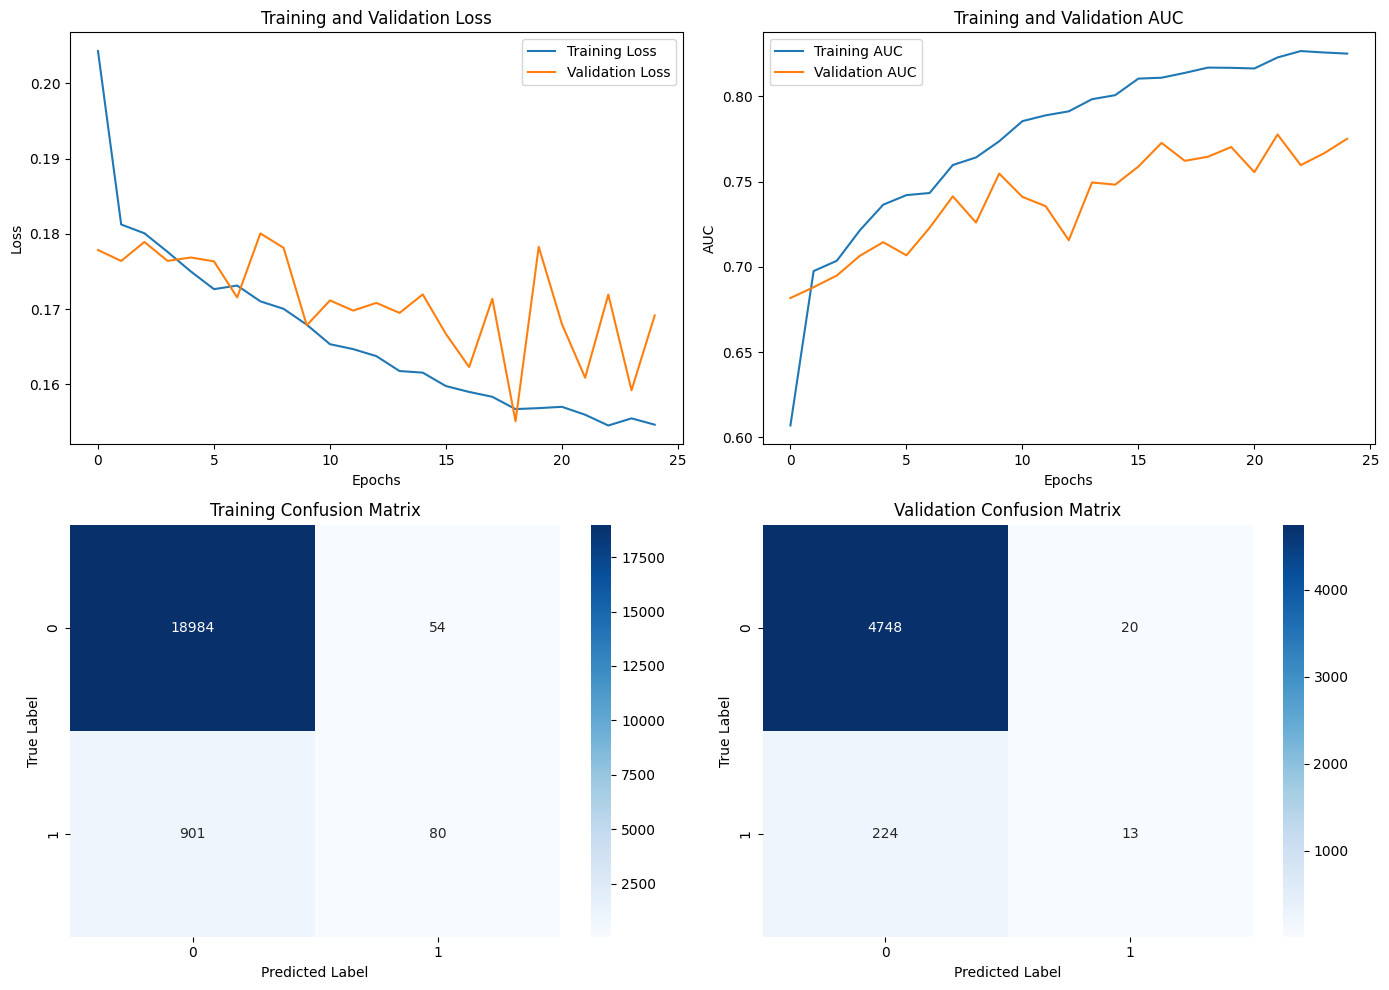

771/771 [==============================] - 3s 3ms/step


In [ ]:
train_and_evaluate(training_set,validation_set,testing_set,tokenizer,model,16,25)

it's give me 79% accuracy on leaderboard let's try to improve it

In [ ]:
# Create a submission file for the Kaggle competition
    submission = pd.DataFrame({'label': y_pred})  # Create a DataFrame for the predictions
    submission.index.name = 'id'  # Set the index name
    submission.to_csv(f'sample_submission_Demo2.csv')  # Save the predictions to a CSV file

**trail 4**

Relational Graph Convolutional Network

In [ ]:
params = GNN.get_default_hyperparameters()
params["num_aggr_MLP_hidden_layer"] = 8
params["hidden_dim"] = 16
params['num_heads']=16
params['message_calculation_class']='rgcn'
params['global_exchange_mode']='gru'
tokenizer,model=preprocess_build_model(training_set,100,200,params)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max (TFOpLa  ()                           0         ['input_3[0][0]']             
 mbda)                                                                                            
                                                                                                  
 embedding (Embedding)       (None, 200)                  20000     ['input_1[0][0]']         

Epoch 1/25


I0000 00:00:1714670073.587288     389 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


626/626 [==============================] - 20s 17ms/step - loss: 0.2192 - auc: 0.5569 - val_loss: 0.1923 - val_auc: 0.6544
Epoch 2/25
626/626 [==============================] - 8s 13ms/step - loss: 0.1805 - auc: 0.6863 - val_loss: 0.1775 - val_auc: 0.6771
Epoch 3/25
626/626 [==============================] - 8s 13ms/step - loss: 0.1771 - auc: 0.7118 - val_loss: 0.1909 - val_auc: 0.7043
Epoch 4/25
626/626 [==============================] - 8s 13ms/step - loss: 0.1749 - auc: 0.7277 - val_loss: 0.1810 - val_auc: 0.6762
Epoch 5/25
626/626 [==============================] - 8s 13ms/step - loss: 0.1745 - auc: 0.7310 - val_loss: 0.1910 - val_auc: 0.6656
Epoch 6/25
626/626 [==============================] - 8s 13ms/step - loss: 0.1751 - auc: 0.7302 - val_loss: 0.1738 - val_auc: 0.7252
Epoch 7/25
626/626 [==============================] - 8s 13ms/step - loss: 0.1729 - auc: 0.7427 - val_loss: 0.1837 - val_auc: 0.6864
Epoch 8/25
626/626 [==============================] - 8s 13ms/step - loss: 0.17

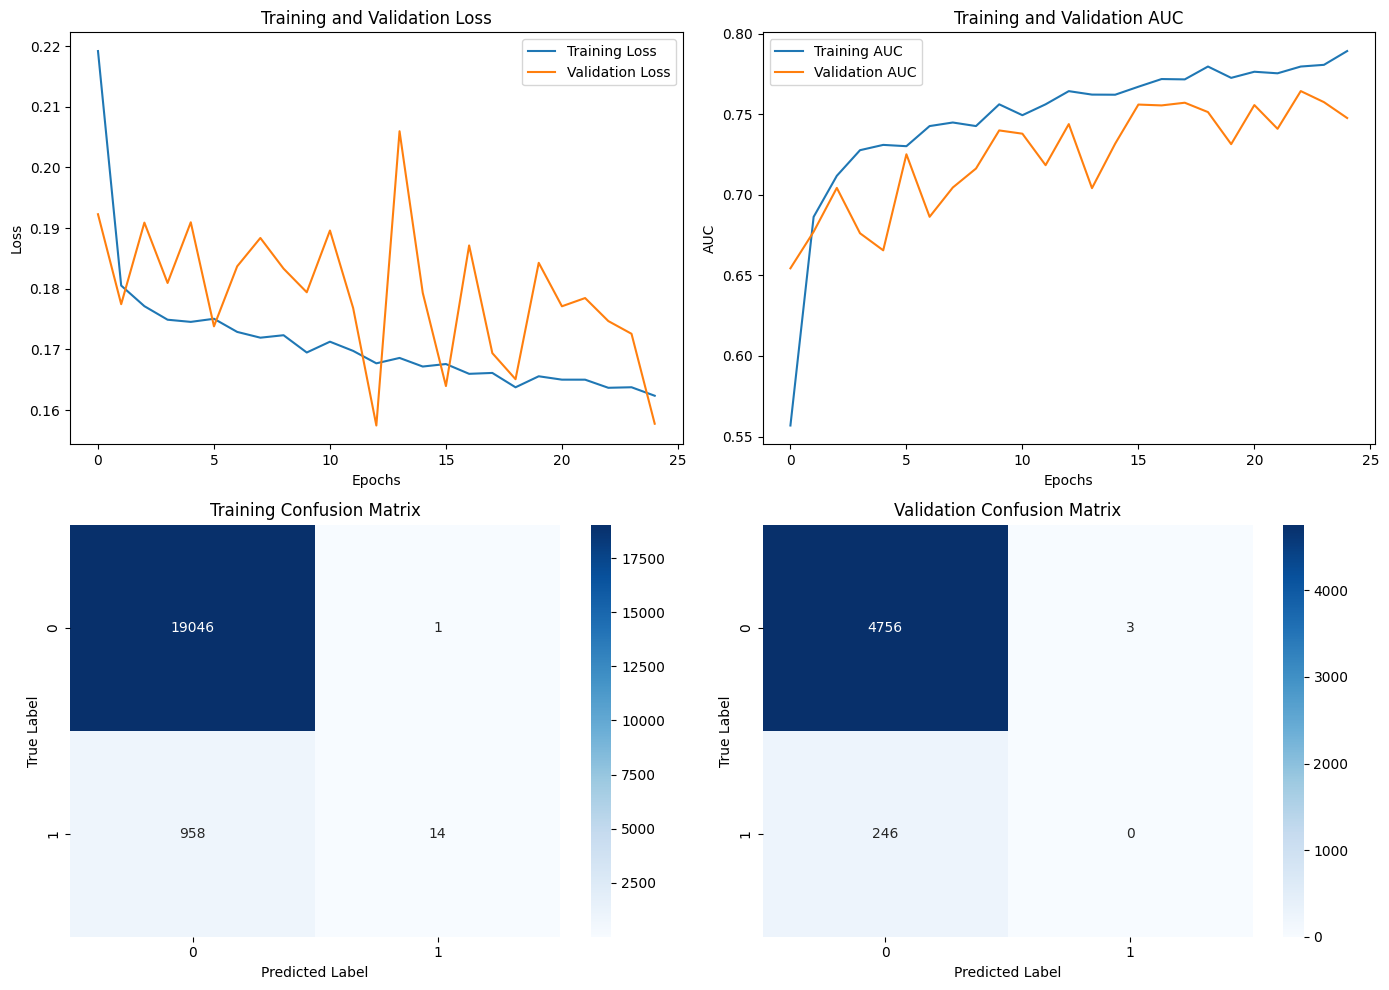

771/771 [==============================] - 3s 4ms/step


In [ ]:
train_and_evaluate(training_set,validation_set,testing_set,tokenizer,model,32,25)

As expected, this model performed badly in identifying the class 1 pattern as well. In a relational graph convolutional network, each node is linked to a feature vector, and each edge is connected with a weight that indicates the relationship between the nodes it connects.


In [ ]:
# Create a submission file for the Kaggle competition
    submission = pd.DataFrame({'label': y_pred})  # Create a DataFrame for the predictions
    submission.index.name = 'id'  # Set the index name
    submission.to_csv(f'sample_submission_withRGCN.csv')  # Save the predictions to a CSV file

**trail 5**

I'll be using rgcn with mean as global_exchange_mode in this trial.
I expect that the model won't provide me with better results because sequence is equally crucial for chemical compounds, but let's still give it a shot.

In [ ]:
params = GNN.get_default_hyperparameters()
params["num_aggr_MLP_hidden_layer"] = 8
params["hidden_dim"] = 32
params['num_heads']=16
params['global_exchange_mode']='mean'
tokenizer,model=preprocess_build_model(training_set,100,200,params)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_1 (TFOp  ()                           0         ['input_6[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 embedding_1 (Embedding)     (None, 200)                  20000     ['input_4[0][0]']       

Epoch 1/25
626/626 [==============================] - 14s 15ms/step - loss: 0.2375 - auc: 0.4994 - val_loss: 0.1987 - val_auc: 0.6168
Epoch 2/25
626/626 [==============================] - 8s 13ms/step - loss: 0.1908 - auc: 0.6138 - val_loss: 0.1939 - val_auc: 0.6450
Epoch 3/25
626/626 [==============================] - 8s 13ms/step - loss: 0.1835 - auc: 0.6708 - val_loss: 0.1888 - val_auc: 0.6966
Epoch 4/25
626/626 [==============================] - 8s 13ms/step - loss: 0.1806 - auc: 0.6833 - val_loss: 0.1925 - val_auc: 0.6076
Epoch 5/25
626/626 [==============================] - 8s 13ms/step - loss: 0.1793 - auc: 0.6916 - val_loss: 0.1783 - val_auc: 0.7049
Epoch 6/25
626/626 [==============================] - 8s 13ms/step - loss: 0.1782 - auc: 0.6938 - val_loss: 0.1850 - val_auc: 0.6587
Epoch 7/25
626/626 [==============================] - 8s 12ms/step - loss: 0.1769 - auc: 0.7075 - val_loss: 0.1924 - val_auc: 0.6939
Epoch 8/25
626/626 [==============================] - 8s 12ms/step -

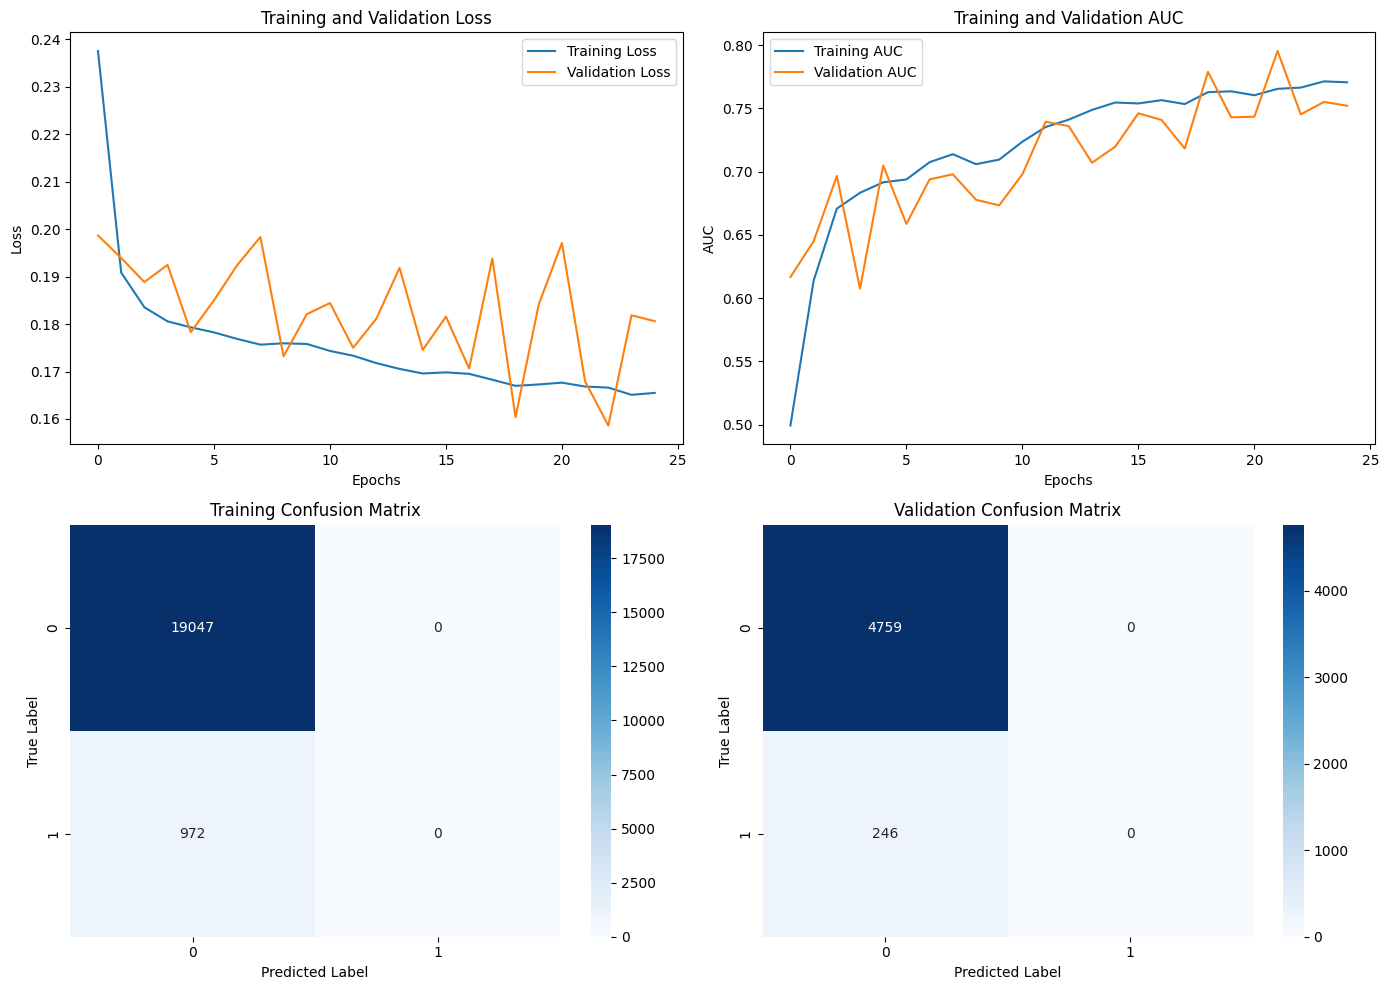

771/771 [==============================] - 3s 4ms/step


In [ ]:
train_and_evaluate(training_set,validation_set,testing_set,tokenizer,model,32,25)

it's give me the worest accuracy this was expected as we ignored the sequence by using mean as global exchange mode

In [ ]:
# Create a submission file for the Kaggle competition
    submission = pd.DataFrame({'label': y_pred})  # Create a DataFrame for the predictions
    submission.index.name = 'id'  # Set the index name
    submission.to_csv(f'sample_submission_withRGCN.csv')  # Save the predictions to a CSV file

**trail 6**

Gated Graph Neural Network

In [ ]:
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["num_heads"] = 8
params['num_aggr_MLP_hidden_layers'] = 12
params["global_exchange_mode"] ='gru'
params['message_calculation_class'] = 'ggnn'
tokenizer,model=preprocess_build_model(training_set,100,200,params)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_2 (TFOp  ()                           0         ['input_9[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 embedding_2 (Embedding)     (None, 200)                  20000     ['input_7[0][0]']       

Epoch 1/35
626/626 [==============================] - 19s 19ms/step - loss: 0.2036 - auc: 0.6035 - val_loss: 0.2054 - val_auc: 0.6357
Epoch 2/35
626/626 [==============================] - 11s 17ms/step - loss: 0.1807 - auc: 0.6709 - val_loss: 0.1828 - val_auc: 0.6555
Epoch 3/35
626/626 [==============================] - 11s 17ms/step - loss: 0.1774 - auc: 0.6890 - val_loss: 0.1870 - val_auc: 0.7007
Epoch 4/35
626/626 [==============================] - 10s 16ms/step - loss: 0.1733 - auc: 0.7199 - val_loss: 0.1804 - val_auc: 0.6739
Epoch 5/35
626/626 [==============================] - 11s 17ms/step - loss: 0.1737 - auc: 0.7221 - val_loss: 0.1648 - val_auc: 0.7307
Epoch 6/35
626/626 [==============================] - 11s 17ms/step - loss: 0.1704 - auc: 0.7455 - val_loss: 0.1863 - val_auc: 0.7362
Epoch 7/35
626/626 [==============================] - 11s 17ms/step - loss: 0.1686 - auc: 0.7548 - val_loss: 0.1886 - val_auc: 0.7072
Epoch 8/35
626/626 [==============================] - 11s 17ms

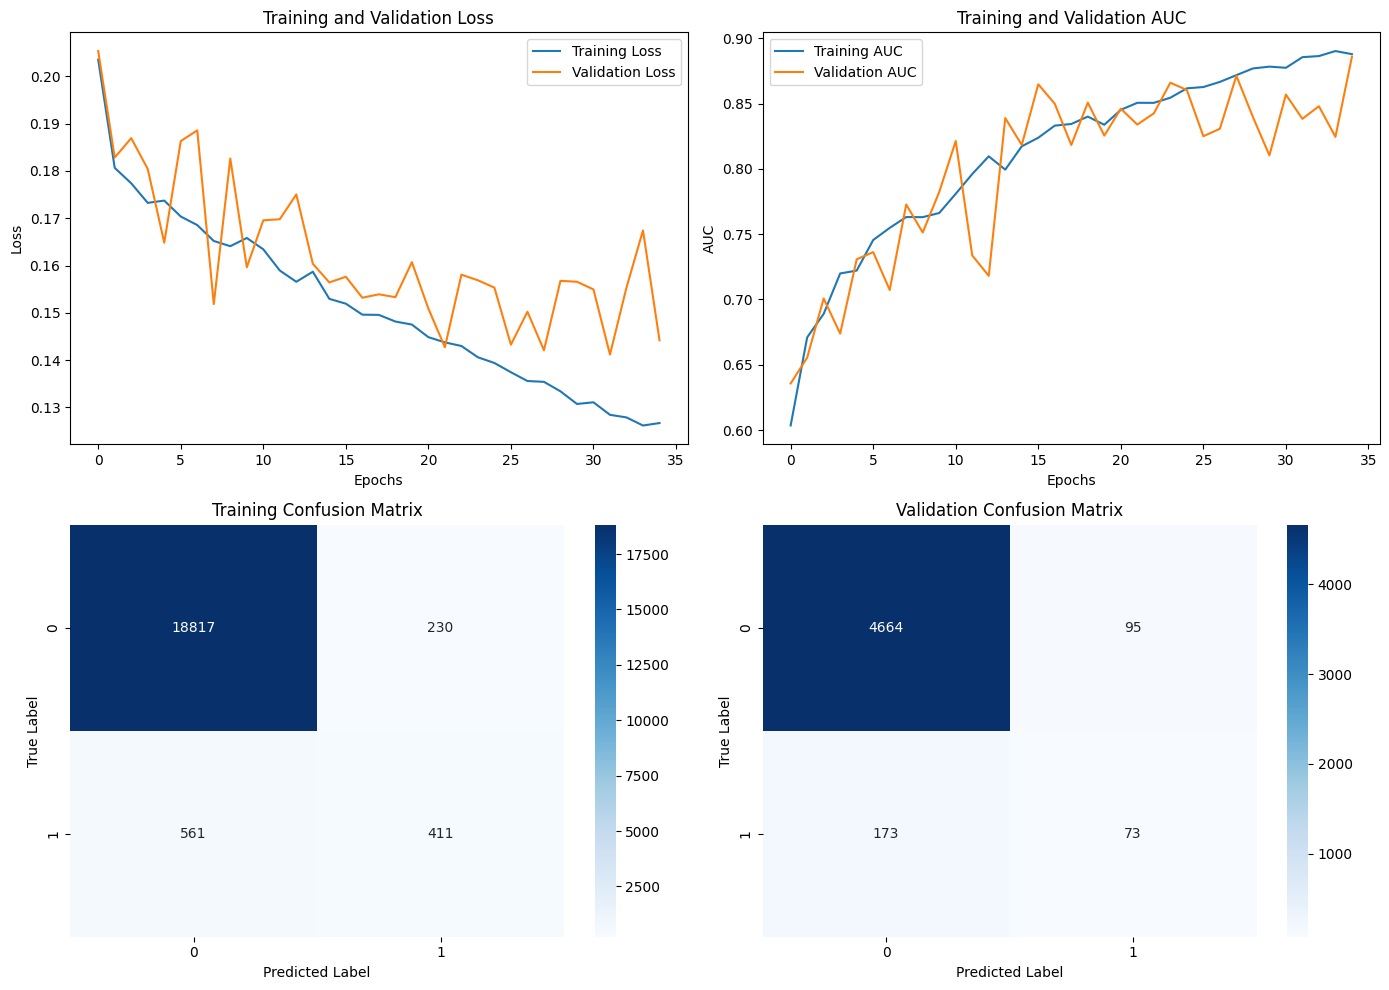

771/771 [==============================] - 4s 5ms/step


In [ ]:
train_and_evaluate(training_set,validation_set,testing_set,tokenizer,model,32,35)

In [ ]:
# Create a submission file for the Kaggle competition
    submission = pd.DataFrame({'label': y_pred})  # Create a DataFrame for the predictions
    submission.index.name = 'id'  # Set the index name
    submission.to_csv(f'sample_submission_GGNN.csv')  # Save the predictions to a CSV file

it's give me 86% accuracy on the leaderboard which better than the others models

**trail 7**
using GNN

In [ ]:
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["num_heads"] = 8
params['num_aggr_MLP_hidden_layers'] = 12
params["global_exchange_mode"] ='gru'
params['message_calculation_class'] = 'ggnn'
tokenizer,model=preprocess_build_model(training_set,100,200,params)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max (TFOpLa  ()                           0         ['input_3[0][0]']             
 mbda)                                                                                            
                                                                                                  
 embedding (Embedding)       (None, 200)                  20000     ['input_1[0][0]']         

Epoch 1/30


I0000 00:00:1714678104.433979     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


626/626 [==============================] - 20s 17ms/step - loss: 0.2054 - auc: 0.5868 - val_loss: 0.1863 - val_auc: 0.6477
Epoch 2/30
626/626 [==============================] - 9s 14ms/step - loss: 0.1853 - auc: 0.6523 - val_loss: 0.1915 - val_auc: 0.6295
Epoch 3/30
626/626 [==============================] - 9s 14ms/step - loss: 0.1824 - auc: 0.6783 - val_loss: 0.1869 - val_auc: 0.6682
Epoch 4/30
626/626 [==============================] - 9s 14ms/step - loss: 0.1780 - auc: 0.6982 - val_loss: 0.1886 - val_auc: 0.6803
Epoch 5/30
626/626 [==============================] - 8s 14ms/step - loss: 0.1717 - auc: 0.7415 - val_loss: 0.1792 - val_auc: 0.7119
Epoch 6/30
626/626 [==============================] - 9s 14ms/step - loss: 0.1672 - auc: 0.7630 - val_loss: 0.1854 - val_auc: 0.7048
Epoch 7/30
626/626 [==============================] - 9s 14ms/step - loss: 0.1662 - auc: 0.7707 - val_loss: 0.1826 - val_auc: 0.7324
Epoch 8/30
626/626 [==============================] - 9s 14ms/step - loss: 0.16

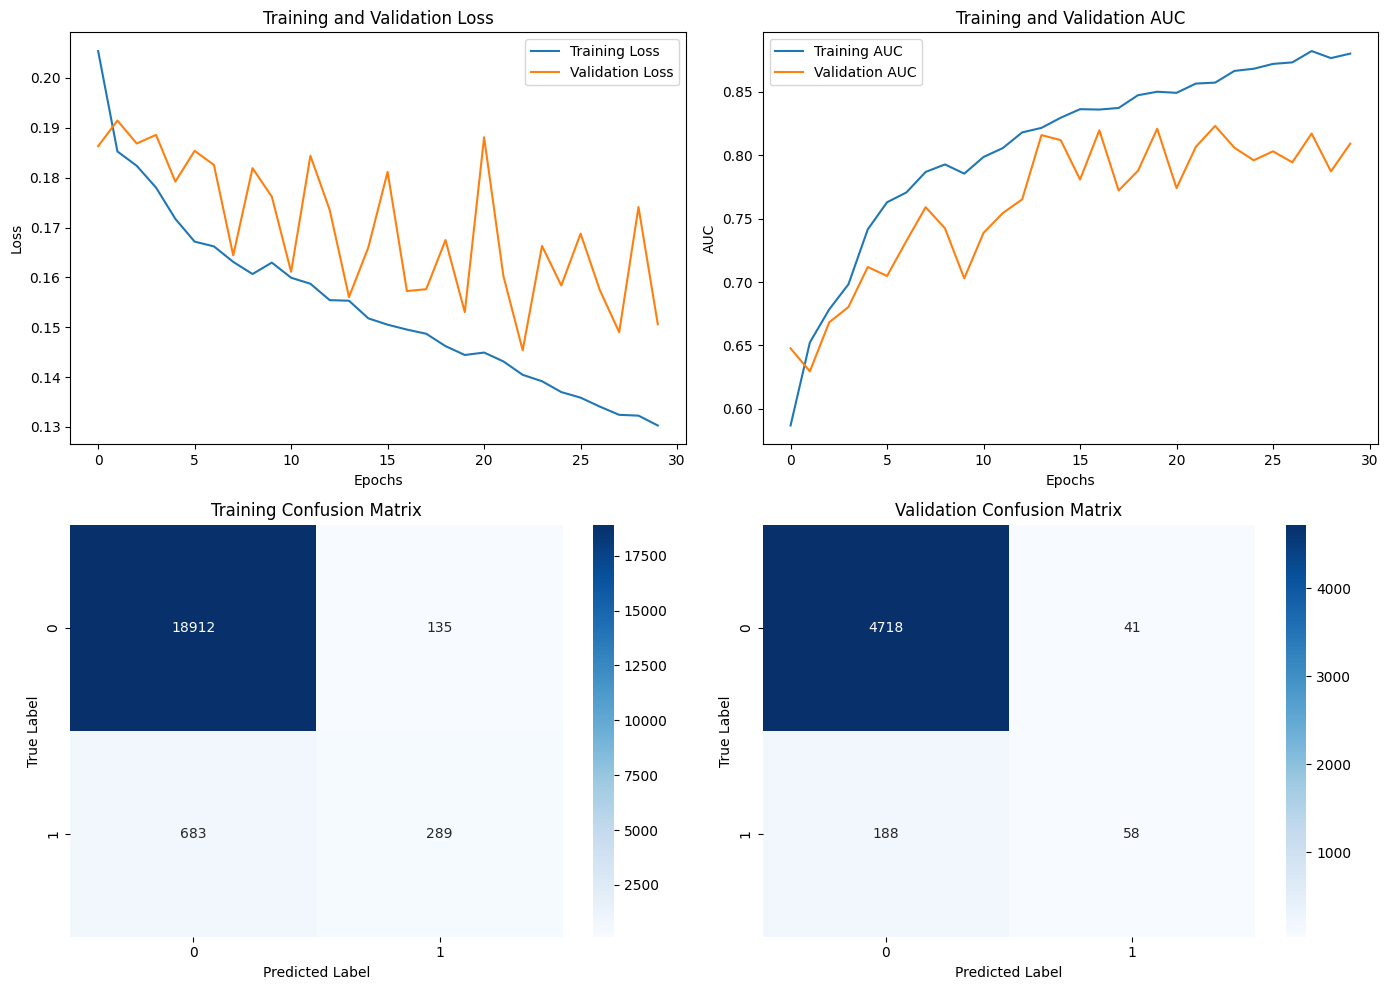

771/771 [==============================] - 3s 4ms/step


In [ ]:
train_and_evaluate(training_set,validation_set,testing_set,tokenizer,model,32,30)

In [ ]:
# Create a submission file for the Kaggle competition
    submission = pd.DataFrame({'label': y_pred})  # Create a DataFrame for the predictions
    submission.index.name = 'id'  # Set the index name
    submission.to_csv(f'sample_submission_GGNN@.csv')  # Save the predictions to a CSV file

**trail 8**
Relational Graph Isomorphism Network (RGIN)

In [ ]:
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["num_heads"] = 8
params['num_aggr_MLP_hidden_layers'] = 16
params["global_exchange_mode"] ='gru'
params['message_calculation_class'] = 'rgin'
tokenizer,model=preprocess_build_model(training_set,100,200,params)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_2 (TFOp  ()                           0         ['input_9[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 embedding_2 (Embedding)     (None, 200)                  20000     ['input_7[0][0]']       

Epoch 1/25
626/626 [==============================] - 28s 23ms/step - loss: 0.2457 - auc: 0.5187 - val_loss: 0.1928 - val_auc: 0.6111
Epoch 2/25
626/626 [==============================] - 13s 21ms/step - loss: 0.1909 - auc: 0.6082 - val_loss: 0.1941 - val_auc: 0.6468
Epoch 3/25
626/626 [==============================] - 14s 22ms/step - loss: 0.1888 - auc: 0.6342 - val_loss: 0.1872 - val_auc: 0.7226
Epoch 4/25
626/626 [==============================] - 14s 22ms/step - loss: 0.1859 - auc: 0.6593 - val_loss: 0.2068 - val_auc: 0.6647
Epoch 5/25
626/626 [==============================] - 13s 21ms/step - loss: 0.1885 - auc: 0.6278 - val_loss: 0.1908 - val_auc: 0.4533
Epoch 6/25
626/626 [==============================] - 13s 21ms/step - loss: 0.1907 - auc: 0.5853 - val_loss: 0.2028 - val_auc: 0.6804
Epoch 7/25
626/626 [==============================] - 14s 22ms/step - loss: 0.1900 - auc: 0.5859 - val_loss: 0.2079 - val_auc: 0.6531
Epoch 8/25
626/626 [==============================] - 13s 21ms

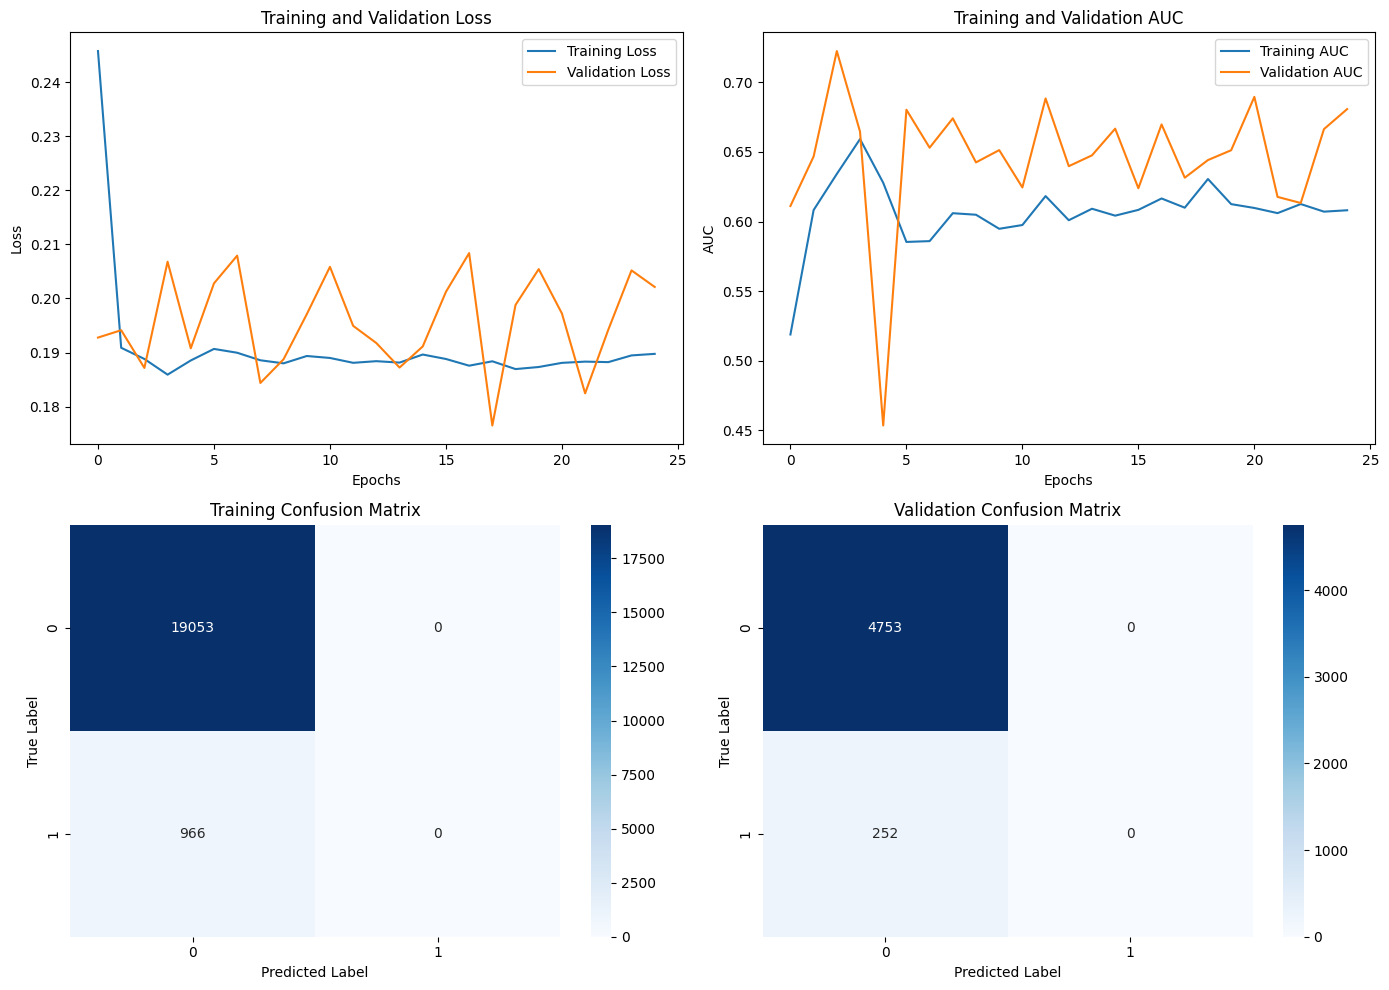

771/771 [==============================] - 4s 5ms/step


In [ ]:
train_and_evaluate(training_set,validation_set,testing_set,tokenizer,model,32,25)

In [ ]:
# Create a submission file for the Kaggle competition
    submission = pd.DataFrame({'label': y_pred})  # Create a DataFrame for the predictions
    submission.index.name = 'id'  # Set the index name
    submission.to_csv(f'sample_submission_RGIN.csv')  # Save the predictions to a CSV file

it gives me the worst accuracy till now

**trail 9**

i will use GNN with droupout

In [ ]:
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 16
params["num_heads"] = 8
params['num_aggr_MLP_hidden_layers'] = 11
params["layer_input_dropout_rate"] = 0.3
params["global_exchange_mode"] ='gru'
params['message_calculation_class'] = 'ggnn'
tokenizer,model=preprocess_build_model(training_set,100,200,params)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_5 (TFOp  ()                           0         ['input_18[0][0]']            
 Lambda)                                                                                          
                                                                                                  
 embedding_5 (Embedding)     (None, 200)                  20000     ['input_16[0][0]']      

Epoch 1/25
626/626 [==============================] - 16s 16ms/step - loss: 0.2080 - auc: 0.5913 - val_loss: 0.1982 - val_auc: 0.6909
Epoch 2/25
626/626 [==============================] - 9s 14ms/step - loss: 0.1871 - auc: 0.6283 - val_loss: 0.1790 - val_auc: 0.6450
Epoch 3/25
626/626 [==============================] - 9s 14ms/step - loss: 0.1861 - auc: 0.6384 - val_loss: 0.1868 - val_auc: 0.6726
Epoch 4/25
626/626 [==============================] - 9s 14ms/step - loss: 0.1858 - auc: 0.6462 - val_loss: 0.1842 - val_auc: 0.7127
Epoch 5/25
626/626 [==============================] - 9s 14ms/step - loss: 0.1812 - auc: 0.6853 - val_loss: 0.1725 - val_auc: 0.6934
Epoch 6/25
626/626 [==============================] - 9s 14ms/step - loss: 0.1784 - auc: 0.7000 - val_loss: 0.1793 - val_auc: 0.7319
Epoch 7/25
626/626 [==============================] - 9s 15ms/step - loss: 0.1771 - auc: 0.6990 - val_loss: 0.1682 - val_auc: 0.7583
Epoch 8/25
626/626 [==============================] - 9s 14ms/step -

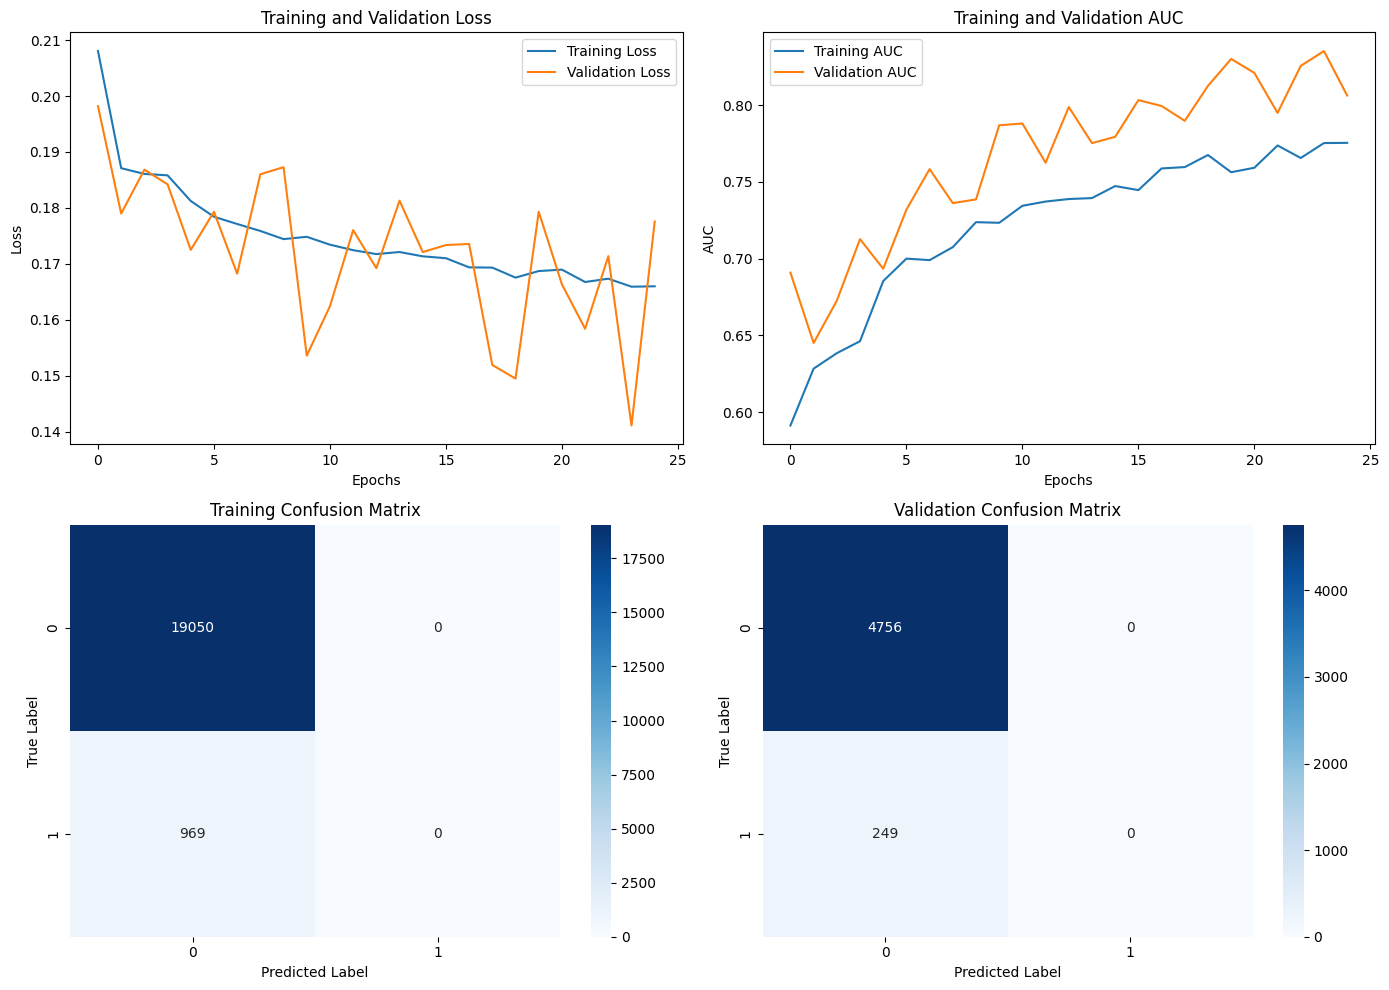

771/771 [==============================] - 3s 4ms/step


In [ ]:
train_and_evaluate(training_set,validation_set,testing_set,tokenizer,model,32,25)

In [ ]:
# Create a submission file for the Kaggle competition
    submission = pd.DataFrame({'label': y_pred})  # Create a DataFrame for the predictions
    submission.index.name = 'id'  # Set the index name
    submission.to_csv(f'sample_submission_GGNN3.csv')  # Save the predictions to a CSV file

it gives me accuracy 80% on leaderboard

**Trial 10**
 using RGAT

In [ ]:
params = GNN.get_default_hyperparameters()
params["num_aggr_MLP_hidden_layer"] =16
params["hidden_dim"] = 32
params['num_heads']=32
params['message_calculation_class']='rgat'
params['global_exchange_mode']='gru'
tokenizer,model=preprocess_build_model(training_set,100,200,params)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_19 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 tf.math.reduce_max_6 (TFOp  ()                           0         ['input_21[0][0]']            
 Lambda)                                                                                          
                                                                                                  
 embedding_6 (Embedding)     (None, 200)                  20000     ['input_19[0][0]']      

Epoch 1/25
1252/1252 [==============================] - 120s 81ms/step - loss: 0.2065 - auc: 0.5743 - val_loss: 0.2009 - val_auc: 0.6583
Epoch 2/25
1252/1252 [==============================] - 99s 79ms/step - loss: 0.1818 - auc: 0.6769 - val_loss: 0.1960 - val_auc: 0.7371
Epoch 3/25
1252/1252 [==============================] - 98s 79ms/step - loss: 0.1765 - auc: 0.7151 - val_loss: 0.1720 - val_auc: 0.7546
Epoch 4/25
1252/1252 [==============================] - 99s 79ms/step - loss: 0.1746 - auc: 0.7299 - val_loss: 0.1723 - val_auc: 0.7753
Epoch 5/25
1252/1252 [==============================] - 99s 79ms/step - loss: 0.1708 - auc: 0.7494 - val_loss: 0.1832 - val_auc: 0.7587
Epoch 6/25
1252/1252 [==============================] - 99s 79ms/step - loss: 0.1696 - auc: 0.7516 - val_loss: 0.1669 - val_auc: 0.7685
Epoch 7/25
1252/1252 [==============================] - 99s 79ms/step - loss: 0.1685 - auc: 0.7606 - val_loss: 0.1713 - val_auc: 0.7691
Epoch 8/25
1252/1252 [=========================

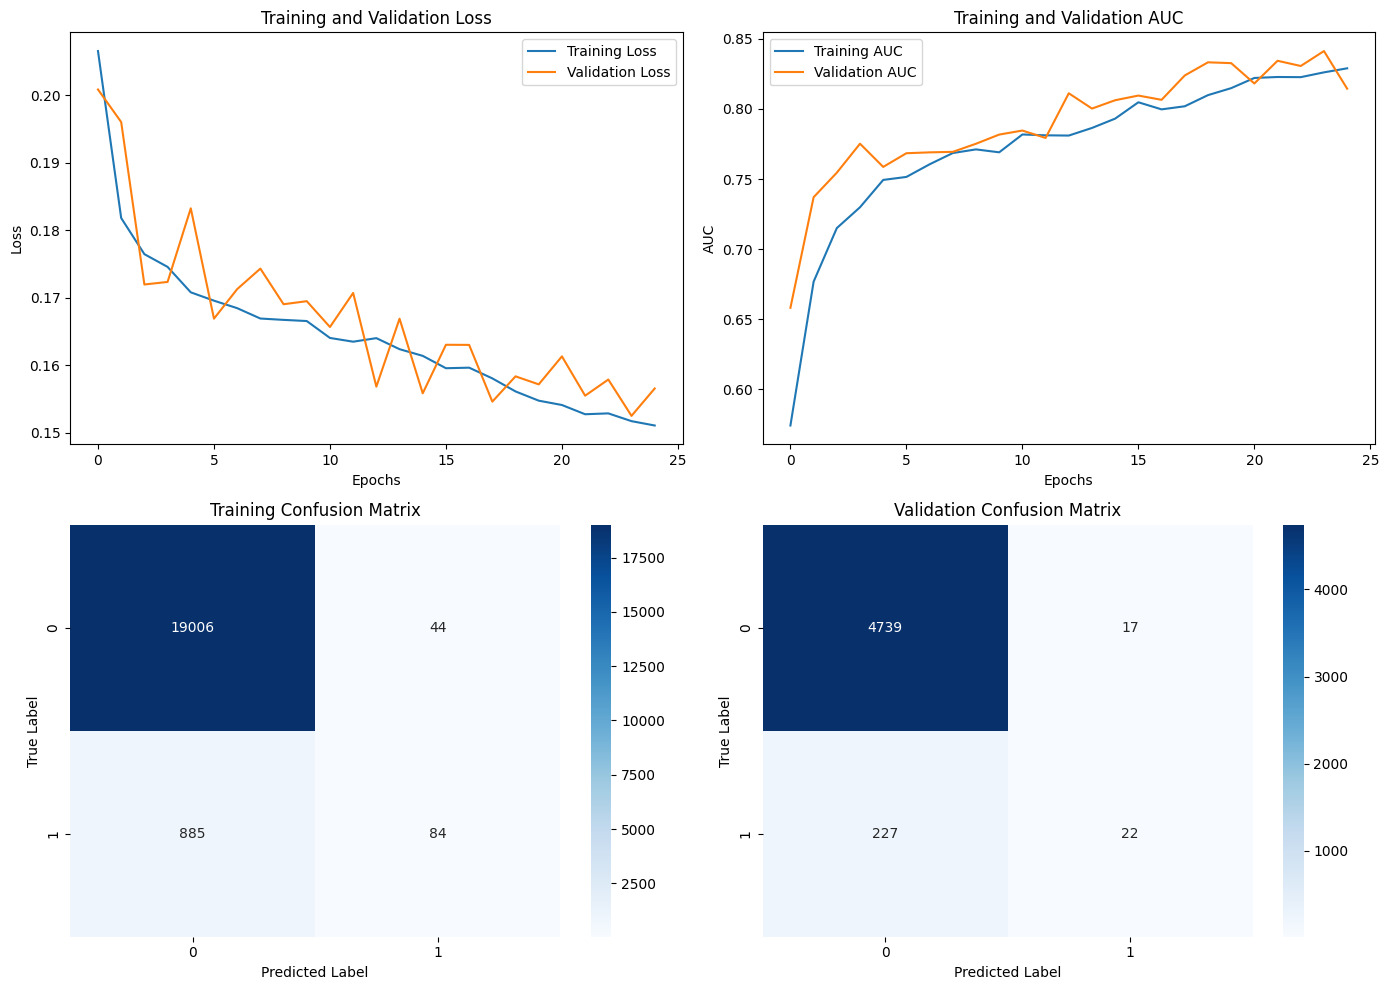

771/771 [==============================] - 11s 15ms/step


In [ ]:
train_and_evaluate(training_set,validation_set,testing_set,tokenizer,model,16,25')

In [ ]:
# Create a submission file for the Kaggle competition
    submission = pd.DataFrame({'label': y_pred})  # Create a DataFrame for the predictions
    submission.index.name = 'id'  # Set the index name
    submission.to_csv(f'sample_submission_RGAT.csv')  # Save the predictions to a CSV file

#  Questions:
## Q1)Based on the provided template, describe the format of the input file (sdf file).
Chemical structures and related data are represented in files using the SDF format, commonly referred to as the Structure Data File format. Text files called "molfiles" hold the structure data for a single molecular molecule. SDFs are made up of several molfiles that have been combined with extra compound-specific data.
The following cells include a clear description.

## Q2)What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?
- In this network, the input tensors are:

data: The tokenized form of the chemical compound's nodes is contained in the data. The extraction of nodes for each compound is followed by tokenization with the tokenizer and padding with the pad_sequence method. Each batch has the shape [batch_size*max_len_nodes], where max_len_nodes is the length of tokenized nodes following padding, and batch_size is the number of samples in the batch.
- edge: the input tensor that contains details about atom-to-atom linkages is called edge. Edges have the shape [sum_of_all_edges,2]. The batch_size is represented by the sum_of_all_edges, which is the total number of edges in each sample. In a batch of three samples, for instance, sample 1 has twenty edges, sample 2 has twenty, and sample 3 has forty. Thus, the edge tensor's size would be [81,2].
- node2graph: This input tensor, which has data on segmented ids, is utilized to calculate the segmented mean. Each batch has the shape [batch_size*max_len_nodes], where max_len_nodes is the length of tokenized nodes following padding, and batch_size is the number of samples in the batch.


## Q3)For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?
- gnn_out: This has the form [batch_size_node_dimension,hidden layers], where batch_size_node_dimension is the batch-specific dimension (i.e., the tokenized vector dimension for the entire batch) of the input data (node). It shows the model's aggregate output for every hidden layer.

- avg: The segmented mean of the gnn_out, determined by the segmented ids, is what is averaged. The output of gnn_out is [tokenized_vector_dimension, hidden_layers] for each sample in the batch_size. There is one segment id per sample. As a result, the segment_mean represents one sample with one number for each hidden layer by taking the mean of all the output data in the gnn_out output. The average tensor's ultimate result has the form [batch_size, hidden_layer]. It is a method of gathering data for every sample and presenting it as mean data.

## Q4)What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?
- Segment_mean calculates the average of the data with identical segmented identifiers.
- reduce_mean: given the parameters, calculates the mean of a tensor's elements across all dimensions.

 To find the mean of tensor elements along different tensor dimensions, use the TensorFlow reduce_mean operation.

- pred: The final output (pred) indicates whether a chemical compound is likely to be active against cancer cells or not. Pred has the shape [batch_size,1]. As a result, the ultimate result for every sample is a number that indicates the likelihood that each chemical molecule will have an activity.

## Q5)What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?
-  The number of levels in the gcn network is implemented using the default template. The documentation specifies that the default layer is 4. The rgcn (Graph Convolution Layers) message transmission technique is the default.

-  A better model is produced by correctly capturing all graph complexity through the use of several gcn.

